In [17]:
import pandas as pd
import warnings
import requests, zipfile, io, os, re
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
warnings.filterwarnings('ignore')

In [18]:
# download file from url, extract it and store it in the dest_folder
def download_and_extract(url, dest_folder):
  r = requests.get(url)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall(dest_folder)

In [19]:
# define folders and urls
healthy_path = './healthy'
healthy_url = 'http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/NewHealthy/Signal.zip'
parkinson_path = './parkinson'
parkinson_url = 'http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/NewPatients/Signal.zip'

In [20]:
download_and_extract(healthy_url, healthy_path)

In [21]:
download_and_extract(parkinson_url, parkinson_path)

In [22]:
# actual downloaded signals
healthy_signals = f'{healthy_path}/Signal/'
parkinson_signals = f'{parkinson_path}/Signal/'
healthy = []
parkinson = []

In [23]:
for filename in os.listdir(healthy_signals):
  if re.search('sigMea', filename) is not None:
    df = pd.read_csv(healthy_signals + filename, sep='\s+', header=None, comment='#')
    healthy.append(df)

for filename in os.listdir(parkinson_signals):
 if re.search('sigMea', filename) is not None:
    df = pd.read_csv(parkinson_signals + filename, sep='\s+', header=None, comment='#')
    parkinson.append(df)


In [24]:
def preprocess(X, y):
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
  X_valid = scaler.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)
  return X_train, X_valid, y_train, y_valid

In [25]:
def create_dataset(healthy, parkinson, seq):
  X = []
  y = []

  # healthy signals
  for df in healthy:
    count = len(df.index) // seq
    for i in range(count):
      X.append((df.iloc[i * seq : (i + 1) * seq]).to_numpy())
      y.append(0)

  # parkinson signals
  for df in parkinson:
    count = len(df.index) // seq
    for i in range(count):
      X.append((df.iloc[i * seq : (i + 1) * seq]).to_numpy())
      y.append(1)

  return np.array(X), np.array(y)


In [26]:
def train_model(X_train, X_valid, y_train, y_valid):
  model = keras.models.Sequential([
  keras.layers.GRU(128, return_sequences=True, input_shape=(X_train.shape[1], 6)),
  keras.layers.GRU(128),
  keras.layers.Dense(1, activation="sigmoid")
  ])

  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
  model.fit(X_train, y_train, epochs = 100, batch_size = 64, validation_data=(X_valid, y_valid))
  return model.evaluate(X_valid, y_valid)



In [27]:
sequence_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
loss = []
accuracy = []


for sequence in sequence_list:
  X, y = create_dataset(healthy, parkinson, sequence)
  X_train, X_valid, y_train, y_valid = preprocess(X, y)
  curr_loss, curr_accuracy = train_model(X_train, X_valid, y_train, y_valid)
  
  loss.append(curr_loss)
  accuracy.append(curr_accuracy)
  print(curr_loss, curr_accuracy)



Epoch 1/100
517/517 [==============================] - 6s 11ms/step - loss: 0.5234 - accuracy: 0.7427
Epoch 2/100
517/517 [==============================] - 6s 11ms/step - loss: 0.4143 - accuracy: 0.8090
Epoch 3/100
517/517 [==============================] - 6s 11ms/step - loss: 0.3316 - accuracy: 0.8520
Epoch 4/100
517/517 [==============================] - 6s 11ms/step - loss: 0.2880 - accuracy: 0.8732
Epoch 5/100
517/517 [==============================] - 6s 11ms/step - loss: 0.2596 - accuracy: 0.8877
Epoch 6/100
517/517 [==============================] - 6s 11ms/step - loss: 0.2450 - accuracy: 0.8947
Epoch 7/100
517/517 [==============================] - 6s 11ms/step - loss: 0.2225 - accuracy: 0.9055
Epoch 8/100
517/517 [==============================] - 6s 11ms/step - loss: 0.2048 - accuracy: 0.9139
Epoch 9/100
517/517 [==============================] - 6s 11ms/step - loss: 0.1822 - accuracy: 0.9245
Epoch 10/100
517/517 [==============================] - 6s 11ms/step - loss: 0.170

In [28]:
loss

[0.25262728333473206,
 0.3797890245914459,
 0.316997230052948,
 0.3165430426597595,
 0.5713289380073547,
 0.5212194919586182,
 0.4450686275959015,
 0.43732815980911255,
 0.42468246817588806,
 0.43318966031074524]

In [29]:
accuracy

[0.9507978558540344,
 0.9459131956100464,
 0.9339416027069092,
 0.9311859607696533,
 0.9235005974769592,
 0.9307805299758911,
 0.9180327653884888,
 0.9179841876029968,
 0.8882681727409363,
 0.8894410133361816]

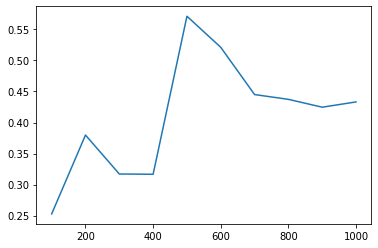

In [30]:
plt.plot(sequence_list, loss)

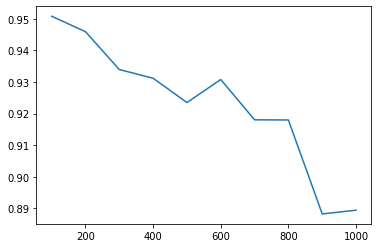

In [31]:
plt.plot(sequence_list, accuracy)